In [1]:
# SETUP : importing

import numpy as np
import pandas as pd

from sklearn.datasets import load_iris

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="darkgrid")

import sklearn.tree as tree
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

import sklearn.metrics as mtr
from scipy import stats
from statsmodels.stats import diagnostic

import utilcompute as uc
import utilplot as up
import preprocessing as pre
import error_metrics as em

C:\Users\danis_p50\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# SETUP : reading in the datasets

data = np.column_stack( (load_iris().data, load_iris().target) )
df = pd.DataFrame(data)
df.columns = [
    'SL',    # sepal length in cm
    'SW',    # sepal width in cm
    'PL',    # petal length in cm
    'PW',    # petal width in cm
    'CL'     # class : {Iris-Setosa, Iris-Versicolour, Iris-Virginica}
]


In [3]:
# SETUP : printing aggregated info

#s = uc.summary(df)
#print(s)

In [4]:
target = 'CL'

if (isinstance(target, list)):
    features = [c for c in df.columns.values.tolist() if (c not in target)]
else:
    features = [c for c in df.columns.values.tolist() if (c != target)]

#print('features : ', features)
#print('target   : ', target)

In [5]:
# SHUFFLING 

seed = 10
np.random.seed(seed)

df = df.reindex(np.random.permutation(df.index))


In [6]:
# SETUP : data split

train_perc = 0.8
delimiter = int(len(df) * train_perc)

df_train = pd.DataFrame( df[:delimiter] ) # train + validation
df_test = pd.DataFrame( df[delimiter:] )  # test


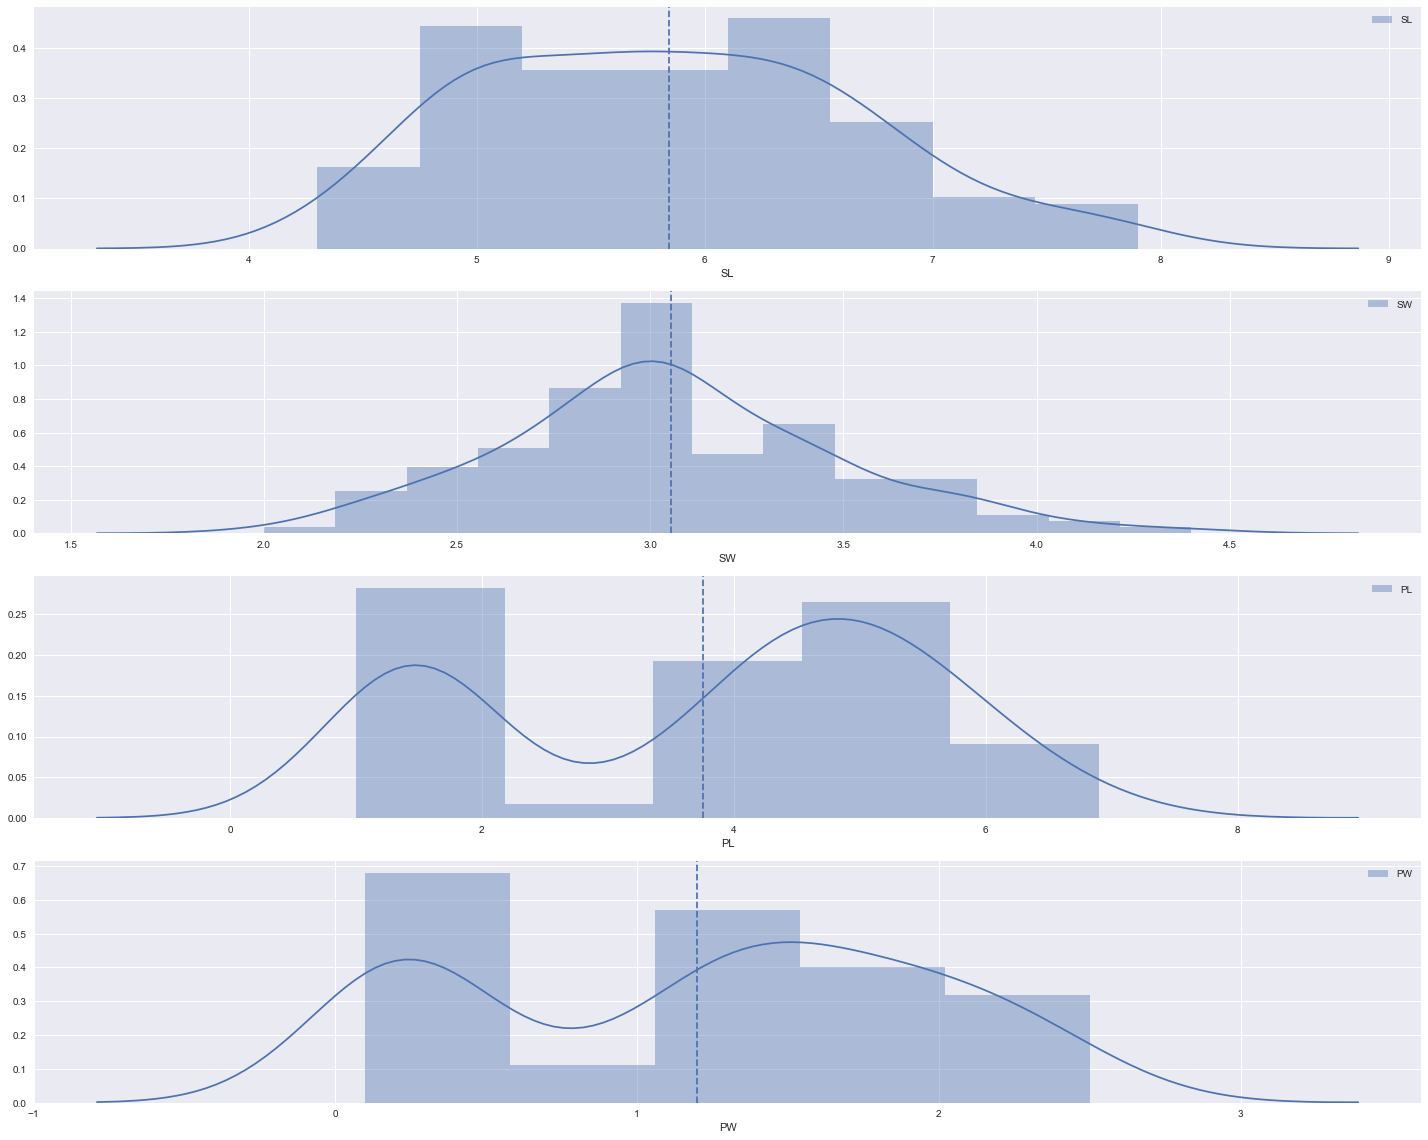

In [7]:
fig, axs = plt.subplots(nrows = len(features), ncols = 1, figsize=(20, 4 * len(features)))    

for (f_index, f) in enumerate(features) :
    ax = axs[f_index]
    subset = df[f]        
    sns.distplot(a= subset, ax = ax, label = f)   
    ax.axvline(x = subset.mean(), linestyle='--')
    ax.legend(loc='best') 

plt.tight_layout()
plt.show()

In [8]:
# DATA PREPROCESSING (TRAIN + VALIDATION) : features transformation

excluded_features = []
included_features = [f for f in features if (f not in excluded_features)]

df_cnt = pre.center(df = df_train, included = included_features, excluded = uc.concatenate(excluded_features,target))
df_std = pre.standardize(df = df_train, included = included_features, excluded = uc.concatenate(excluded_features,target))


In [9]:
# DATA PREPROCESSING (TEST) : features transformation

df_cnt_test = pre.center(df = df_test, included = included_features, excluded = uc.concatenate(excluded_features,target))
df_std_test = pre.standardize(df = df_test, included = included_features, excluded = uc.concatenate(excluded_features,target))


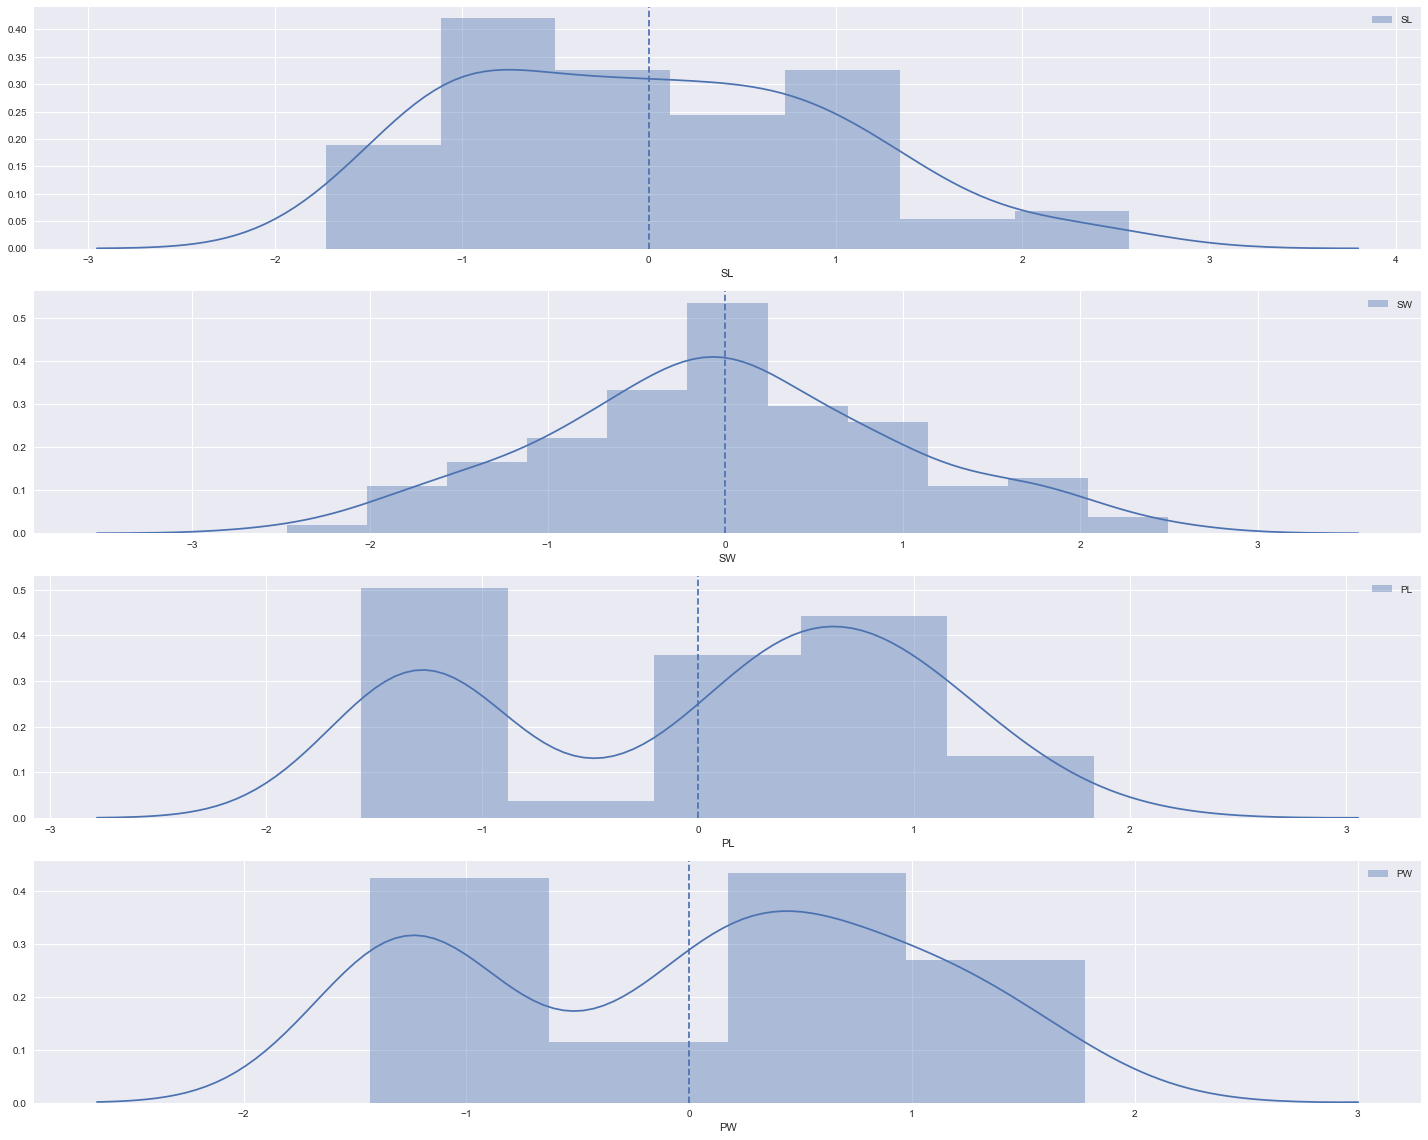

In [10]:
fig, axs = plt.subplots(nrows = len(features), ncols = 1, figsize=(20, 4 * len(features)))    

for (f_index, f) in enumerate(features) :
    ax = axs[f_index]
    subset = df_std[f]        
    sns.distplot(a= subset, ax = ax, label = f)   
    ax.axvline(x = subset.mean(), linestyle='--')
    ax.legend(loc='best') 

plt.tight_layout()
plt.show()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_max_depth', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'split5_test_score', 'split6_test_score', 'split7_test_score', 'split8_test_score', 'split9_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'split5_train_score', 'split6_train_score', 'split7_train_score', 'split8_train_score', 'split9_train_score', 'mean_train_score', 'std_train_score'])
[1 2 3 4 5 6 7 8 9 10]
[ 1  2  3  4  5  6  7  8  9 10]


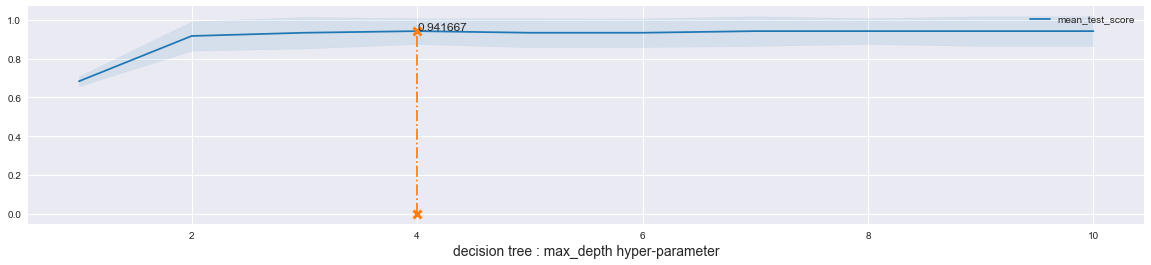

In [11]:
max_depth = np.arange(1, 10 + 1)

grid = GridSearchCV(
    estimator = tree.DecisionTreeClassifier(), 
    param_grid = {'max_depth': max_depth},   
    refit = False,
    cv = 10
)

grid.fit(df_std[features], df_std[target])
grid_results = grid.cv_results_

print(grid_results.keys())
print(grid_results['param_max_depth'])
print(max_depth)

up.plot_gridsearch_cv(
    param_name = 'param_max_depth', 
    scoring_list = {'score' : 'mean_test_score'},
    grid_results = grid_results, 
    plot_args = {'xticks' : max_depth, 'xscale' : 'linear', 'xlabel' : 'decision tree : max_depth hyper-parameter'}
)


In [12]:
dectree_list = [
    { 'df' : df_train, 'module' : tree, 'model_name' : 'DecisionTreeClassifier', 
      'model_args' : {'criterion' : 'gini', 'splitter' : 'best', 'max_depth' : 3}, 'model_attributes' : None, 
      'note' : 'original' 
    },
    #{ 'df' : df_sk, ''module' : tree, 'model_name' : 'DecisionTreeClassifier', 
    # 'model_args' : {'criterion' : 'mse', 'splitter' : 'best', 'max_depth' : 3}, 'note' : 'un-skewed' },
    { 'df' : df_cnt, 'module' : tree, 'model_name' : 'DecisionTreeClassifier', 
     'model_args' : {'criterion' : 'gini', 'splitter' : 'best', 'max_depth' : 3}, 'model_attributes' : None, 
     'note' : 'centered' 
    },
    { 'df' : df_std, 'module' : tree, 'model_name' : 'DecisionTreeClassifier', 
     'model_args' : {'criterion' : 'gini', 'splitter' : 'best', 'max_depth' : 3}, 'model_attributes' : None, 
     'note' : 'standardized'
    }    
]

results = pd.DataFrame()

for l in dectree_list:
    results_temp = uc.compute_kfold_stats(
        df = l['df'], 
        features = features, 
        target = [target], 
        module = l['module'],
        model_name = l['model_name'], 
        model_args = l['model_args'],
        model_attributes = l['model_attributes'],
        note = l['note'],
        task = 'classification',
        debug = False
    )
    results = results.append(results_temp).reset_index(drop = True)


C:\Users\danis_p50\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1307: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
C:\Users\danis_p50\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1432: RuntimeWarning: invalid value encountered in double_scalars
  return self.mse_model/self.mse_resid
C:\Users\danis_p50\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\danis_p50\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\danis_p50\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
C:\Users\danis_p50\Anaconda3\lib\site-packa

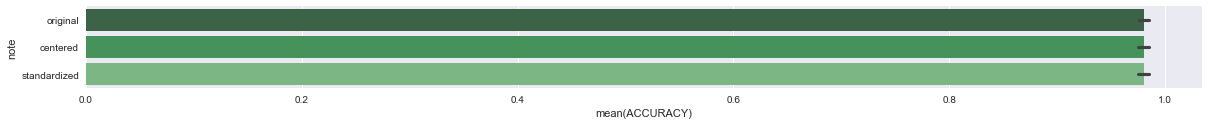

ACCURACY mean (original) :                             0.9806
ACCURACY mean (centered) :                             0.9806
ACCURACY mean (standardized):                             0.9806


In [13]:
metric = 'ACCURACY'

up.plot_across_discriminant(
    df = results, 
    cols = [metric], 
    discriminant_col = 'note', 
    plot_args = {'title' : 'decision tree learning', 'skewness' : False, 'normality' : False}, 
    distplot = False,
    sem      = False, 
    adj_sem  = False,
    mean     = True
)


discriminant_values = results['note'].unique().tolist() 
template = "{0:25}:{1:>35}" 
for (d_index,d) in enumerate(discriminant_values):
    label = ('{0} mean ({1})'.format(metric, d))    
    criteria = (results['note'] == d)    
    subset = results[criteria][metric]        
    print(template.format(label, round(subset.mean(), 4)))